In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Utility
import os

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

In [2]:
# Set visibible GPU
gpu_num: int = 0
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [3]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory, get_gpu_device
gpu_grow_memory(verbose=True)

Found 1 GPUs.  Setting memory growth = True.


In [4]:
# MSE Imports
from asteroid_search import load_fitted_elts, load_ztf_hits, append_fitted_elt, append_ztf_hit, file_name_model
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from random_elements import load_best_random_elts, make_ztf_ast
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

In [7]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

## Review Fitted Elements

In [56]:
known_ast = True
min_hits = 8
max_res: float = 20.0

In [57]:
fitted_elts = load_fitted_elts(known_ast=known_ast, min_hits=min_hits)
best_element_id = fitted_elts.element_id.iloc[0]

In [59]:
is_good = fitted_elts.R_sec < max_res
good_elts = fitted_elts[is_good]

In [60]:
good_elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R_sec,thresh_sec,log_like,hits,num_rows_close,timestamp
element_id,,,,,,,,,,,,,,,
132055,132055,3.001259,0.106583,0.176153,5.593913,0.756441,-0.352044,58600.0,121.977325,9.303388,619.304016,835.913879,121.978065,169.0,2020-04-29 15:01:48.732245
146842,146842,3.014638,0.103410,0.226416,0.944375,2.602004,-2.829622,58600.0,94.908264,9.994537,429.287781,523.118469,72.948471,142.0,2020-04-30 03:34:01.879423
13172,13172,2.574177,0.177445,0.172849,2.846966,2.930934,-5.419372,58600.0,72.941956,6.534205,445.092957,474.436218,65.986427,95.0,2020-04-24 08:08:48.008207
167580,167580,3.197130,0.166593,0.129728,0.458809,0.868540,-1.704000,58600.0,66.167297,17.522427,842.223572,335.577515,65.877655,204.0,2020-04-30 19:01:37.113547
57218,57218,2.896754,0.044306,0.014004,4.265533,0.151008,2.625664,58600.0,84.132111,12.023473,625.552429,391.802307,58.903355,263.0,2020-04-25 21:50:46.937329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103865,103865,2.751578,0.129661,0.187366,3.997306,3.907498,4.668955,58600.0,11.814208,12.141571,960.405579,41.130836,7.939591,241.0,2020-04-27 12:46:05.975632
6741,6741,2.648119,0.111147,0.149182,0.990966,3.100657,-3.746168,58600.0,13.441545,12.266848,801.999573,46.874134,7.938081,213.0,2020-04-24 03:10:43.553064
101616,101616,2.269106,0.157780,0.098134,1.597945,3.080391,-4.575845,58600.0,18.399300,18.559063,1284.034790,61.150887,7.930385,393.0,2020-04-28 02:37:05.823431


In [61]:
# plt.hist(fitted_elts.R_sec)

In [63]:
num_elts: int = good_elts.shape[0]
print(f'found {num_elts} good elements with at least {min_hits} hits and R_sec < {max_res} arc seconds.')

found 125 good elements with at least 8 hits and R_sec < 20.0 arc seconds.


In [64]:
# fitted_elts.loc[best_element_id]

In [67]:
# mean resolution
R_mean = np.mean(good_elts.R_sec)
R_geomean = np.exp(np.mean(np.log(good_elts.R_sec)))

In [68]:
# report resolution
print(f'Mean resolution   : {R_mean:6.2f} arc sec')
print(f'GeoMean resolution: {R_geomean:6.2f} arc sec')

Mean resolution   :  13.44 arc sec
GeoMean resolution:  12.77 arc sec


In [69]:
# ast_elt.loc[best_element_id]

In [70]:
# fitted_elts.to_csv('../data/candidate_elt/fitted_elts_unknown.csv')

## Review ZTF Hits

In [71]:
ztf_hits = load_ztf_hits(known_ast=known_ast, display=True, min_hits=min_hits)

In [72]:
ztf_hits = ztf_hits.loc[good_elts.element_id]

In [73]:
num_hits: int = ztf_hits.shape[0]
hits_per_elt = num_hits / num_elts
print(f'Found {num_hits} ZTF hits against {num_elts} fitted elements.')
print(f'Mean {hits_per_elt:6.2f} hits per element')

Found 2229 ZTF hits against 125 fitted elements.
Mean  17.83 hits per element


In [74]:
ztf_hits.loc[best_element_id]

,element_id,ztf_id,ObjectID,CandidateID,mjd,ra,dec,mag_app,ux,uy,uz,elt_ux,elt_uy,elt_uz,s_sec,timestamp
ztf_id,,,,,,,,,,,,,,,,
295360,132055,295360,b'ZTF19abiqsfg',936426032615015002,58690.426030,21.866386,17.735163,18.165300,0.883949,0.446640,0.138373,0.883953,0.446630,0.138375,2.328738,2020-04-29 15:01:48.732245
310252,132055,310252,b'ZTF19abirulk',936465272615015005,58690.465278,21.872681,17.740909,18.815901,0.883882,0.446757,0.138426,0.883886,0.446747,0.138429,2.279108,2020-04-29 15:01:48.732245
403714,132055,403714,b'ZTF19abjqbbp',939466822415015033,58693.466829,22.349309,18.171013,18.153999,0.878759,0.455525,0.142408,0.878764,0.455514,0.142410,2.577831,2020-04-29 15:01:48.732245
409044,132055,409044,b'ZTF19abjpaws',939428542415015016,58693.428542,22.343676,18.165550,18.480700,0.878822,0.455420,0.142355,0.878827,0.455409,0.142357,2.584019,2020-04-29 15:01:48.732245
554537,132055,554537,b'ZTF19ablqfvv',942477522415015007,58696.477523,22.786146,18.591572,17.755600,0.873845,0.463610,0.146495,0.873851,0.463598,0.146495,2.870188,2020-04-29 15:01:48.732245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5278400,132055,5278400,b'ZTF20aanmcfz',1140151486215015010,58894.151481,26.930536,21.076985,18.903200,0.831909,0.530786,0.161842,0.831902,0.530796,0.161846,2.607394,2020-04-29 15:01:48.732245
5278406,132055,5278406,b'ZTF20aanmcfz',1140152395115015012,58894.152396,26.930815,21.077073,19.027201,0.831907,0.530790,0.161842,0.831900,0.530800,0.161846,2.651502,2020-04-29 15:01:48.732245
5520038,132055,5520038,b'ZTF20aapqmoj',1146140625815015007,58900.140625,29.007368,21.568770,18.981001,0.813318,0.559983,0.157899,0.813307,0.559999,0.157902,3.979879,2020-04-29 15:01:48.732245


In [75]:
cols = ['mjd', 'ra', 'dec', 'mag_app', 's_sec']
ztf_hits[cols].loc[best_element_id]

,mjd,ra,dec,mag_app,s_sec
ztf_id,,,,,
295360,58690.426030,21.866386,17.735163,18.165300,2.328738
310252,58690.465278,21.872681,17.740909,18.815901,2.279108
403714,58693.466829,22.349309,18.171013,18.153999,2.577831
409044,58693.428542,22.343676,18.165550,18.480700,2.584019
554537,58696.477523,22.786146,18.591572,17.755600,2.870188
...,...,...,...,...,...
5278400,58894.151481,26.930536,21.076985,18.903200,2.607394
5278406,58894.152396,26.930815,21.077073,19.027201,2.651502
5520038,58900.140625,29.007368,21.568770,18.981001,3.979879


In [77]:
# ztf_hits.to_csv('../data/candidate_elt/ztf_hits_known.csv')

## Visualize Results

In [141]:
plot_x = np.arange(num_elts)+1
height = np.round(good_elts.hits)
mean_height = np.mean(height)
ref_height = 20

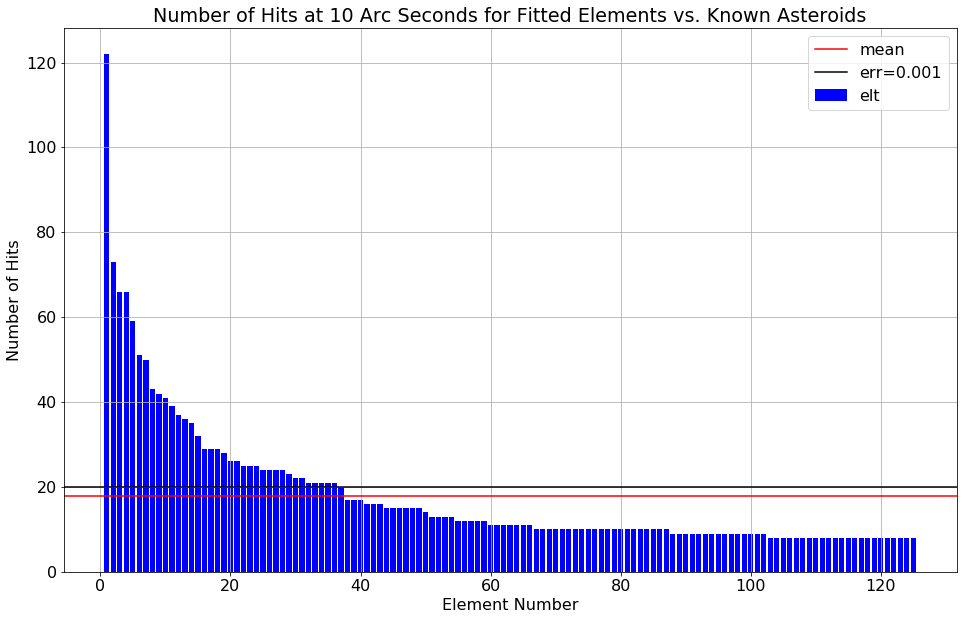

In [142]:
# Plot number of hits
fig, ax = plt.subplots()
ax.set_title('Number of Hits at 10 Arc Seconds for Fitted Elements vs. Known Asteroids')
ax.set_xlabel('Element Number')
ax.set_ylabel('Number of Hits')
ax.bar(x=plot_x, height=height, label='elt', color='blue')
ax.axhline(y=mean_height, label='mean', color='red')
ax.axhline(y=ref_height, label=f'err=0.001', color='black')
ax.grid()
ax.legend()
plt.show()

In [143]:
fig.savefig('../figs/search_known/random/hits.png', bbox_inches='tight')

In [ ]:
# Plot of resolution
plot_x = np.arange(num_elts)+1
height = good_elts.R_sec
mean_height = np.exp(-np.mean(np.log(good_elts.R_sec)))
ref_height = 1.0 / 10.0

In [ ]:
# Plot number of hits
fig, ax = plt.subplots()
ax.set_title('Log Likelihood for Fitted Elements vs. Known Asteroids')
ax.set_xlabel('Element Number')
ax.set_ylabel('Log Likelihood')
ax.bar(x=plot_x, height=height, label='elt', color='blue')
ax.axhline(y=mean_height, label='mean', color='red')
ax.axhline(y=ref_height, label=f'err=0.001', color='black')
ax.grid()
ax.legend()
plt.show()

In [123]:
# Plot of resolution
plot_x = np.arange(num_elts)+1
height = 1.0 / good_elts.R_sec
mean_height = np.exp(-np.mean(np.log(good_elts.R_sec)))
ref_height = 1.0 / 10.0

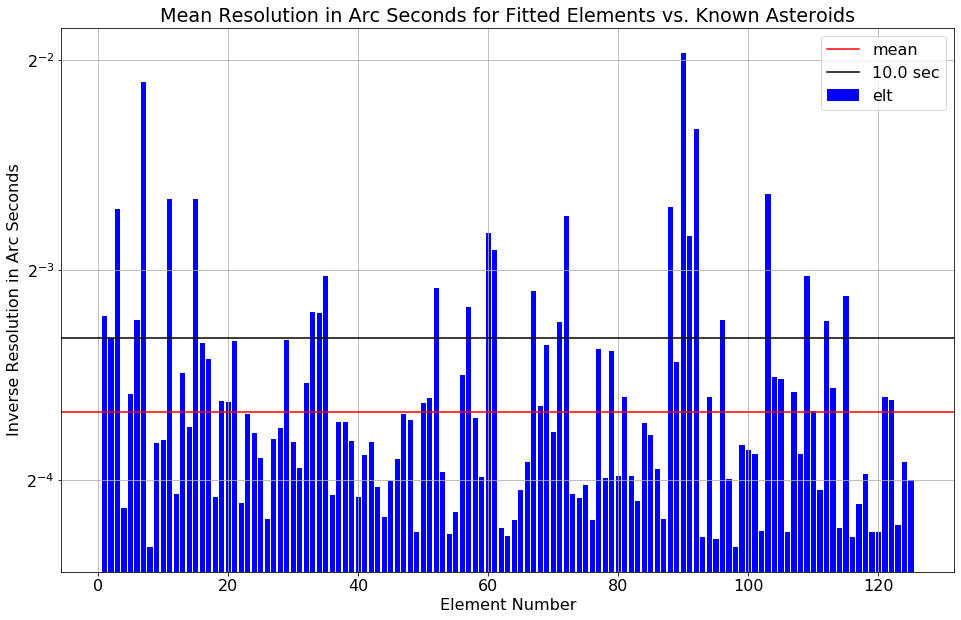

In [124]:
# Plot number of hits
fig, ax = plt.subplots()
ax.set_title('Mean Resolution in Arc Seconds for Fitted Elements vs. Known Asteroids')
ax.set_xlabel('Element Number')
ax.set_ylabel('Inverse Resolution in Arc Seconds')
ax.bar(x=plot_x, height=height, label='elt', color='blue')
ax.axhline(y=mean_height, label='mean', color='red')
ax.axhline(y=ref_height, label=f'10.0 sec', color='black')
ax.set_yscale('log', basey=2)
ax.grid()
ax.legend()
plt.show()

In [125]:
fig.savefig('../figs/search_known/random/resolution.png', bbox_inches='tight')

## Nearest Asteroid

In [ ]:
# near_ast_elt = nearest_ast_elt_cart(elts=good_elts)

In [131]:
q_norm = elt_q_norm(elts=good_elts, ast_num=near_ast_elt.nearest_ast_num)

In [132]:
near_ast_elt['q_norm'] = q_norm

In [133]:
near_ast_elt

,element_id,nearest_ast_num,nearest_ast_name,nearest_ast_dist,a,e,inc,Omega,omega,f,epoch,q_norm
0,132055,16144,Korsten,0.000068,3.001207,0.106751,0.176149,5.593885,0.751905,-0.347746,58600.0,0.010786
1,146842,2573,Hannu Olavi,0.000479,3.015706,0.105709,0.226341,0.944392,2.584818,-2.811504,58600.0,0.054085
2,13172,26703,2001 FB144,0.000569,2.571910,0.175808,0.172841,2.846739,2.927330,-5.413980,58600.0,0.023343
3,167580,11205,1999 FY28,0.000356,3.198915,0.167837,0.129754,0.458829,0.871939,-1.706923,58600.0,0.018486
4,57218,459814,2013 SM33,0.003641,2.899326,0.018254,0.021427,3.718312,1.442226,-4.368272,58600.0,2.711167
...,...,...,...,...,...,...,...,...,...,...,...,...
120,103865,152228,2005 SK9,0.004442,2.762316,0.161908,0.131599,3.897159,4.069944,4.517167,58600.0,0.997032
121,6741,364406,2006 VW120,0.004038,2.650839,0.108820,0.204093,0.956806,3.117901,-3.670807,58600.0,0.575896
122,101616,9434,Bokusen,0.003653,2.272446,0.141517,0.047427,0.943397,3.852457,1.495425,58600.0,2.422270
123,122026,57503,2001 ST252,0.003995,2.329552,0.013485,0.040836,1.636104,5.410376,-0.706965,58600.0,1.915571


In [139]:
geomean_dist = np.exp(np.mean(np.log(near_ast_elt.nearest_ast_dist)))
print(f'Geometric mean distance to nearest asteroid {geomean_dist:6.2e}.')

Geometric mean distance to nearest asteroid 2.68e-03.


In [126]:
# Plot of position error
plot_x = np.arange(num_elts)+1
height = 1.0 / near_ast_elt.nearest_ast_dist
mean_height = np.exp(np.mean(np.log(height)))
ref_height = 1.0 / 0.001

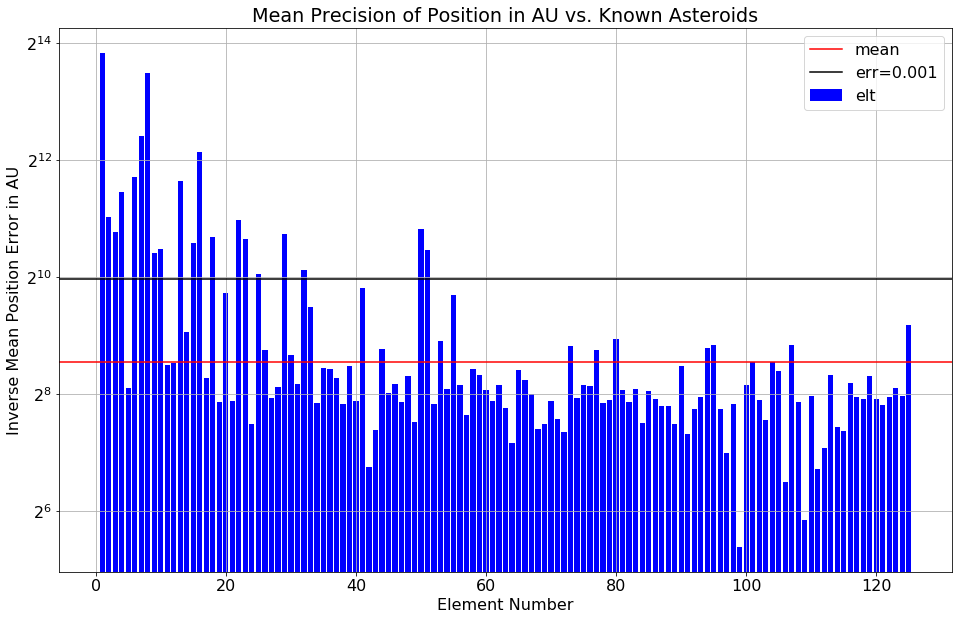

In [127]:
# Plot position error in AU
fig, ax = plt.subplots()
ax.set_title('Mean Precision of Position in AU vs. Known Asteroids')
ax.set_xlabel('Element Number')
ax.set_ylabel('Inverse Mean Position Error in AU')
ax.bar(x=plot_x, height=height, label='elt', color='blue')
ax.axhline(y=mean_height, label='mean', color='red')
ax.axhline(y=ref_height, label=f'err=0.001', color='black')
ax.set_yscale('log', basey=2)
ax.grid()
ax.legend()
plt.show()

In [128]:
fig.savefig('../figs/search_known/random/near_ast_dist.png', bbox_inches='tight')

In [134]:
# Plot of cov error
plot_x = np.arange(num_elts)+1
height = 1.0 / near_ast_elt.q_norm
mean_height = np.exp(np.mean(np.log(height)))
ref_height = 1.0 / 0.001

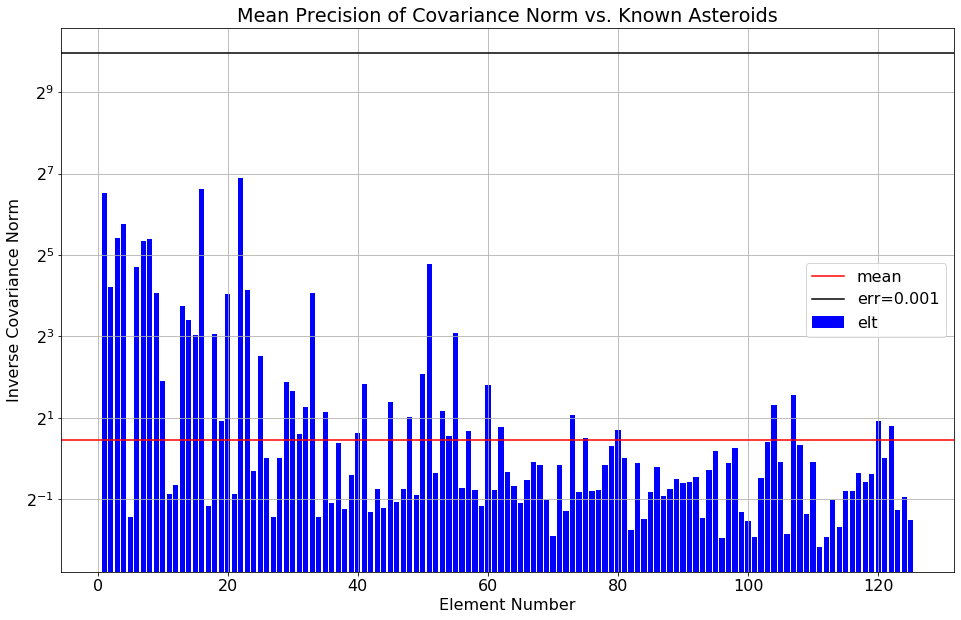

In [135]:
# Plot position error in AU
fig, ax = plt.subplots()
ax.set_title('Mean Precision of Covariance Norm vs. Known Asteroids')
ax.set_xlabel('Element Number')
ax.set_ylabel('Inverse Covariance Norm')
ax.bar(x=plot_x, height=height, label='elt', color='blue')
ax.axhline(y=mean_height, label='mean', color='red')
ax.axhline(y=ref_height, label=f'err=0.001', color='black')
ax.set_yscale('log', basey=2)
ax.grid()
ax.legend()
plt.show()

## Load ZTF Data and Batch of Orbital Elements

In [ ]:
# Parameters to build random orbital elements and ztf_ast
batch_size_init = 1024
batch_size = 64
random_seed = best_element_id // batch_size
thresh_deg = 2.0

In [ ]:
# Load ztf nearest asteroid data
ztf_ast = make_ztf_ast(known_ast=known_ast)

In [ ]:
# # Review ztf_ast
# ztf_ast

In [ ]:
# Best random elements
elts = load_best_random_elts(random_seed=random_seed, known_ast=known_ast, 
                             batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

In [ ]:
# # Review best random elements
# elts

In [ ]:
ztf_ast.loc[ztf_id_close]

In [ ]:
close_ast_num = ztf_ast.nearest_ast_num.loc[ztf_id_close].mode().values[0]
close_ast_num

In [ ]:
nearest_ast_dist = ztf_ast.nearest_ast_dist.loc[ztf_id_close]

In [ ]:
dist2sec(nearest_ast_dist)

## Batches of ZTF Data Near Initial Candidate Elements

In [ ]:
# Arguments to make_ztf_batch
near_ast = False
regenerate = False

In [ ]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, ztf=ztf_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [ ]:
# # Review ZTF elements
# ztf_elt

In [ ]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [ ]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [ ]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [ ]:
# # Review perturbed elements; includes nearest asteroid number and distance
# elts

## Build Asteroid Search Model

In [ ]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [ ]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0

In [ ]:
# The file name for the saved model
file_name = file_name_model(seed=random_seed, known_ast=known_ast, 
                            batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

In [ ]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model',
                file_name=file_name,
)

In [ ]:
# Load trained model
model.load()

In [ ]:
# Report before training starts
model.report()

In [ ]:
# Generate fitted elements
elts_fit = model.candidates_df()

In [ ]:
cols = ['element_id', 'a', 'e', 'inc', 'Omega', 'omega', 'f', 'epoch',
        'num_hits', 'R', 'R_deg', 'R_sec', 'R_max', 'R_deg_max', 'thresh_s',
        'thresh_deg', 'thresh_sec', 'log_like', 'hits', 'num_rows_close']

In [ ]:
elts_fit[cols]

In [ ]:
# Save ztf_hits to ztf_hits_known_ast or ztf_unknown_ast

In [ ]:
# Generate ZTF hits
ztf_hit = model.calc_ztf_hits()

In [ ]:
# ztf_hit

In [ ]:
elts_fit, elts_near_ast = model.nearest_ast()

In [ ]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 5)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
mean_R_sec = np.mean(model.elts_fit.R_sec[is_converged])
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_q_norm[is_converged])))

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Resolution in arc sec  : {mean_R_sec:5.2f}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

In [ ]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])